# Final Unsupervised Learning Project: Hotel Recommendations
In this project, I’m working with data from the Expedia Hotel Recommendations Kaggle competition. The dataset includes logs of customer behavior, such as hotel searches, clicks, bookings, and whether the trip was part of a travel package. It also includes extra features about destinations, based on hotel reviews.

Expedia groups similar hotels into what they call hotel clusters. These clusters are based on things like price, location, and customer ratings. While the original goal of the competition is to predict which hotel cluster a user will book, this project takes a different approach. Instead of using labels to predict outcomes, I’m using unsupervised learning to explore patterns in the data.

The main goals of this project are:
- Use Principal Component Analysis (PCA) to reduce the number of features to keep the most important information.

- Use clustering to group users or search events by similar behavior travel distance, location, or whether they use mobile or book packages.

- Build a simple recommender system to suggest hotel clusters to users based on the groups they belong to.

By doing this, I hope to better understand different types of travelers and how their behavior can be used to improve hotel recommendations, even when there are no direct labels or ratings from them.

In [1]:
# Import necessary libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Data Analysis and Data Preprocessing

In [3]:
# Inspect the datasets, shapes, and missing values
display(train.head())
display(test.head())

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nMissing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


Train shape: (37670293, 24)
Test shape: (2528243, 22)

Missing values in train:
date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47083
srch_co                         47084
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: i

In [4]:
# Clean datatypes
train['date_time'] = pd.to_datetime(train['date_time'], format='mixed')
train['srch_ci'] = pd.to_datetime(train['srch_ci'], format='mixed', errors='coerce')
train['srch_co'] = pd.to_datetime(train['srch_co'], format='mixed', errors='coerce')

test['date_time'] = pd.to_datetime(test['date_time'], format='mixed')
test['srch_ci'] = pd.to_datetime(test['srch_ci'], format='mixed', errors='coerce')
test['srch_co'] = pd.to_datetime(test['srch_co'], format='mixed', errors='coerce')

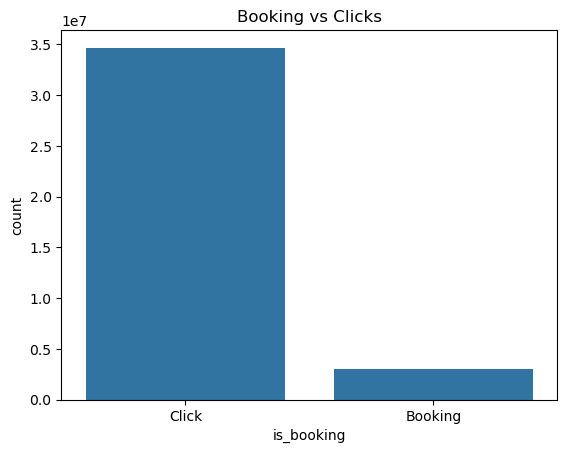

In [5]:
# Ratio of bookings vs. clicks
sns.countplot(data=train, x='is_booking')
plt.title("Booking vs Clicks")
plt.xticks([0, 1], ['Click', 'Booking'])
plt.show()

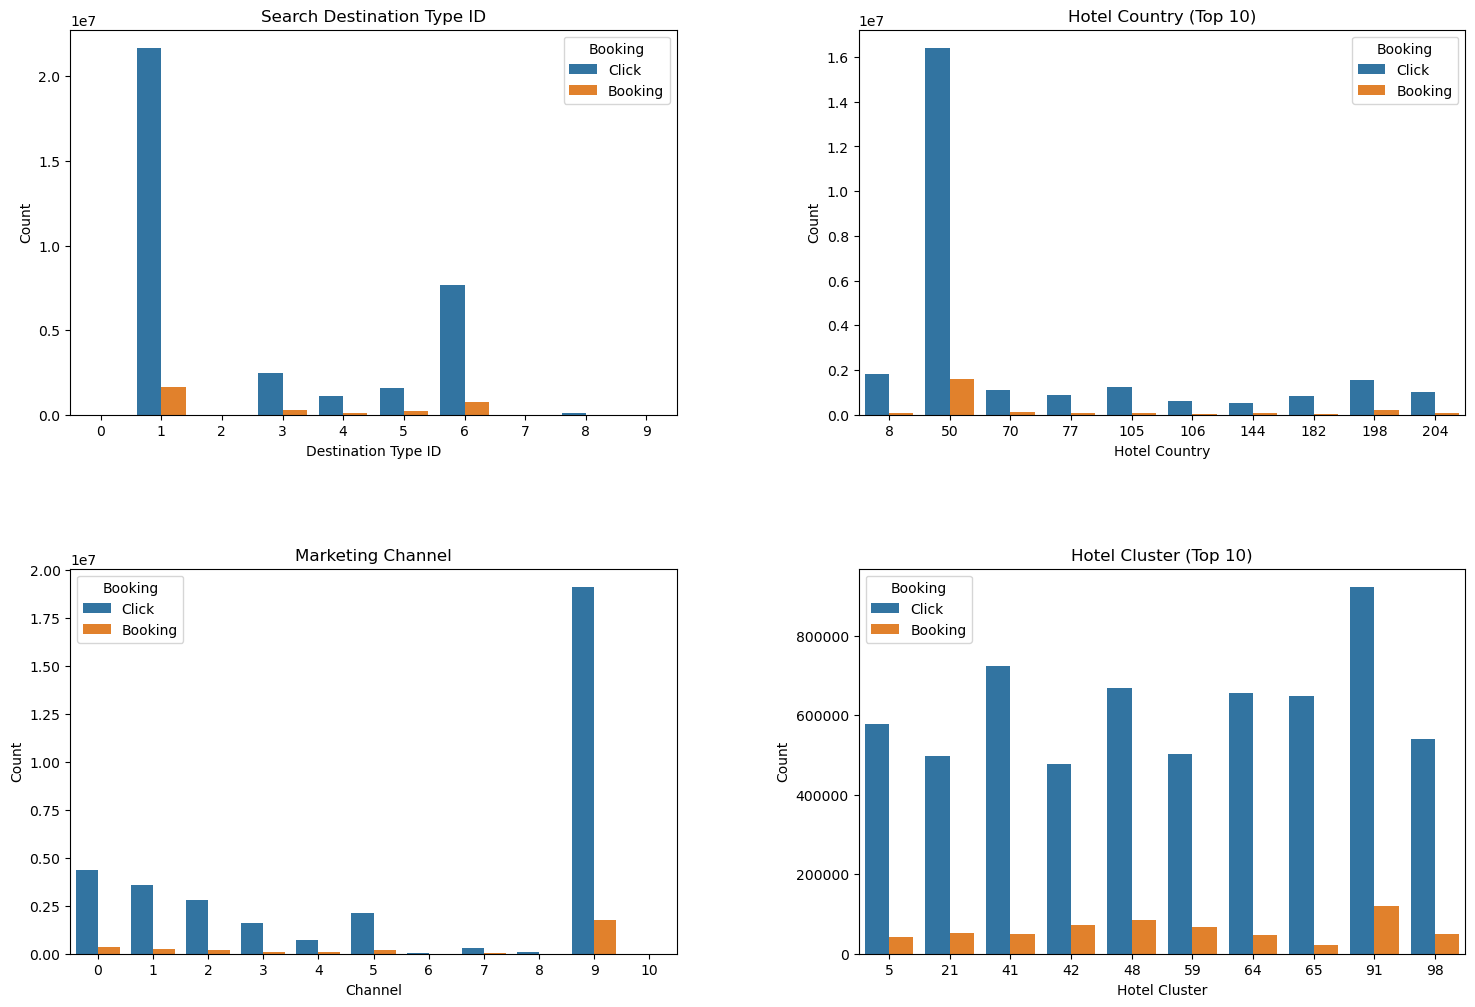

In [6]:
# Distributions of srch_destination_type_id, hotel_country, channel, and hotel_cluster resulting in bookings or not

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

#srch_destination_type_id
sns.countplot(
    ax=axes[0, 0],
    data=train[train['srch_destination_type_id'].isin(train['srch_destination_type_id'].value_counts().index)],
    x='srch_destination_type_id',
    hue='is_booking'
)
axes[0, 0].set_title('Search Destination Type ID')
axes[0, 0].set_xlabel('Destination Type ID')
axes[0, 0].set_ylabel('Count')

# hotel_country
sns.countplot(
    ax=axes[0, 1],
    data=train[train['hotel_country'].isin(train['hotel_country'].value_counts().head(10).index)],
    x='hotel_country',
    hue='is_booking'
)
axes[0, 1].set_title('Hotel Country (Top 10)')
axes[0, 1].set_xlabel('Hotel Country')
axes[0, 1].set_ylabel('Count')

# channel
sns.countplot(
    ax=axes[1, 0],
    data=train[train['channel'].isin(train['channel'].value_counts().index)],
    x='channel',
    hue='is_booking'
)
axes[1, 0].set_title('Marketing Channel')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Count')

# Hotel cluster
sns.countplot(
    ax=axes[1, 1],
    data=train[train['hotel_cluster'].isin(train['hotel_cluster'].value_counts().head(10).index)],
    x='hotel_cluster',
    hue='is_booking'
)
axes[1, 1].set_title('Hotel Cluster (Top 10)')
axes[1, 1].set_xlabel('Hotel Cluster')
axes[1, 1].set_ylabel('Count')

# legend
for ax in axes.flat:
    ax.legend(title='Booking', labels=['Click', 'Booking'])

plt.show()

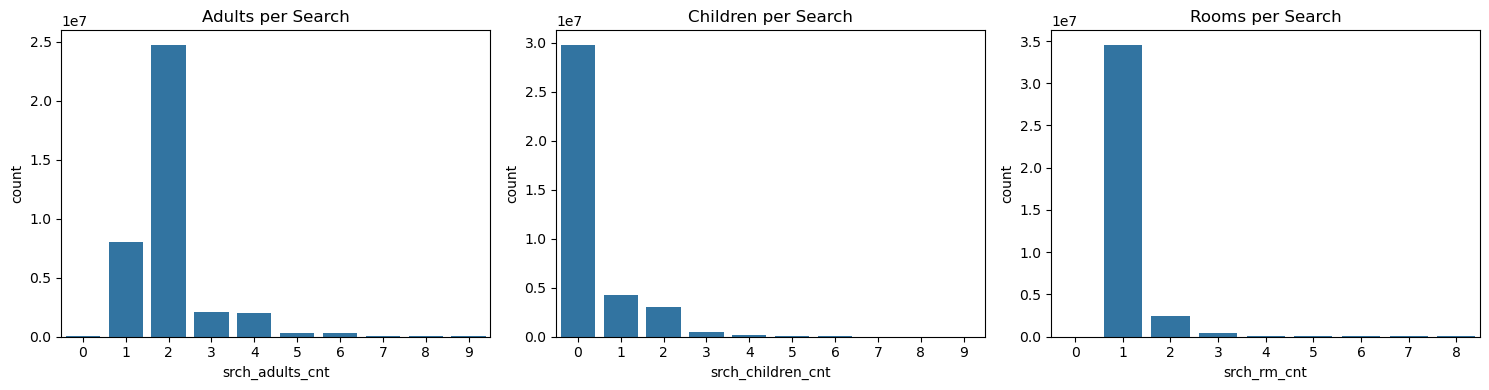

In [7]:
# Search filters
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(ax=axes[0], data=train, x='srch_adults_cnt')
sns.countplot(ax=axes[1], data=train, x='srch_children_cnt')
sns.countplot(ax=axes[2], data=train, x='srch_rm_cnt')
axes[0].set_title("Adults per Search")
axes[1].set_title("Children per Search")
axes[2].set_title("Rooms per Search")
plt.tight_layout()
plt.show()

<Axes: xlabel='is_package', ylabel='count'>

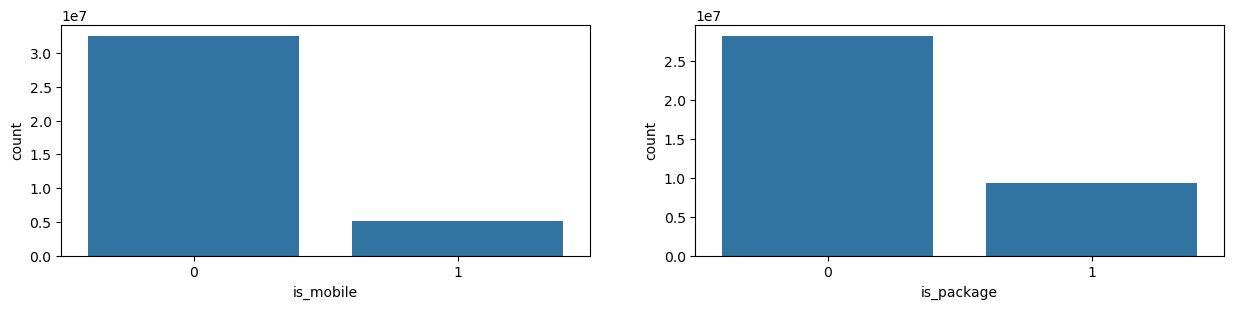

In [8]:
# Mobile Hotel Searches/Package Hotel Searches
fig, axes = plt.subplots(1,2,figsize=(15,3))

sns.countplot(x='is_mobile',data=train, ax=axes[0])

sns.countplot(x='is_package',data=train,  ax=axes[1])

# Principal Component Analysis (PCA)
To reduce the number of features for training data to keep the most important information.

In [9]:
# Data Preprocessing
train_clean = train.copy()

# Drop columns that shouldn't go into PCA
cols_to_drop = [
    'date_time', 'srch_ci', 'srch_co', 'user_id', 
    'srch_destination_id', 'hotel_cluster' 
]

train_clean = train_clean.drop(columns=cols_to_drop)
train_clean = train_clean.dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_clean)

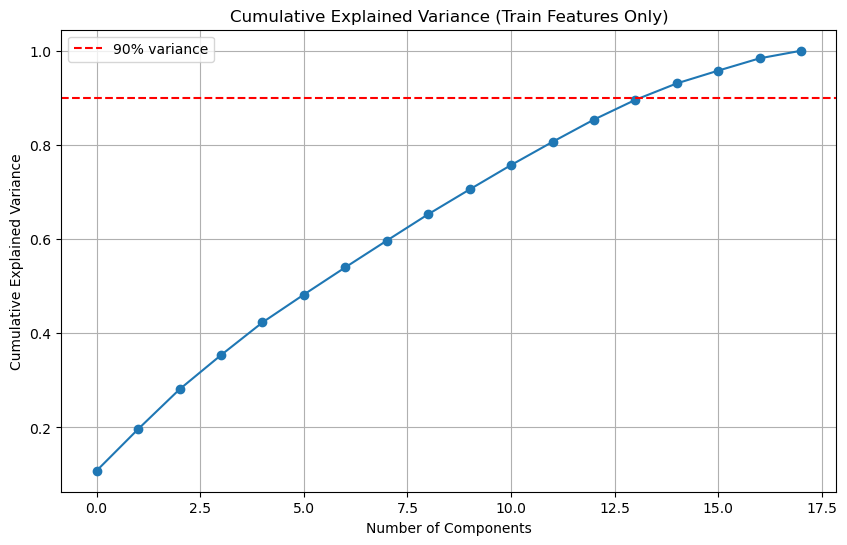

In [10]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance (Train Features Only)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.9, color='red', linestyle='--', label='90% variance')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Components explaining 90% variance
n_components = 13
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Create PCA DataFrame
pca_columns = [f'PC{i+1}' for i in range(n_components)]
train_pca_df = pd.DataFrame(X_pca_reduced, columns=pca_columns)

train_pca_df['is_booking'] = train.loc[train_clean.index, 'is_booking'].values

# K-means Clustering
With output of PCA

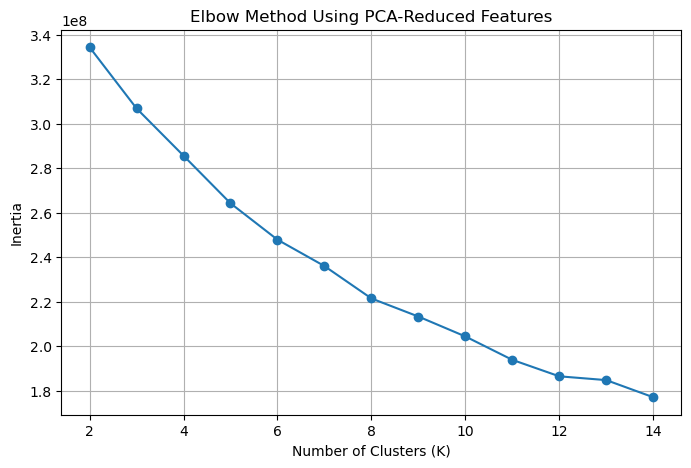

In [12]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca_reduced)
    inertia.append(km.inertia_)

# Elbow plot to determine optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method Using PCA-Reduced Features')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [13]:
# Define consistent columns to drop (exclude target/label columns like 'hotel_cluster', 'cnt', 'is_booking')
cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id', 'srch_destination_id', 'hotel_cluster', 'cnt', 'is_booking']
cols_to_drop2 = ['date_time', 'srch_ci', 'srch_co', 'user_id', 'srch_destination_id', 'id']

# Drop unwanted columns and rows with NaNs
train_clean = train.drop(columns=cols_to_drop, errors='ignore').dropna()
test_clean = test.drop(columns=cols_to_drop2, errors='ignore').dropna()

# Align test_clean's columns to match train_clean
common_columns = list(set(train_clean.columns) & set(test_clean.columns))
train_clean = train_clean[common_columns]
test_clean = test_clean[common_columns]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_clean)
X_test_scaled = scaler.transform(test_clean)

# Apply PCA
n_components = 13
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit KMeans on PCA-reduced training data
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_pca_reduced)
test_clusters = kmeans.predict(X_test_pca)

# Assign clusters back to original DataFrames
train['kmeans_cluster'] = -1
test['kmeans_cluster'] = -1
train.loc[train_clean.index, 'kmeans_cluster'] = train_clusters
test.loc[test_clean.index, 'kmeans_cluster'] = test_clusters

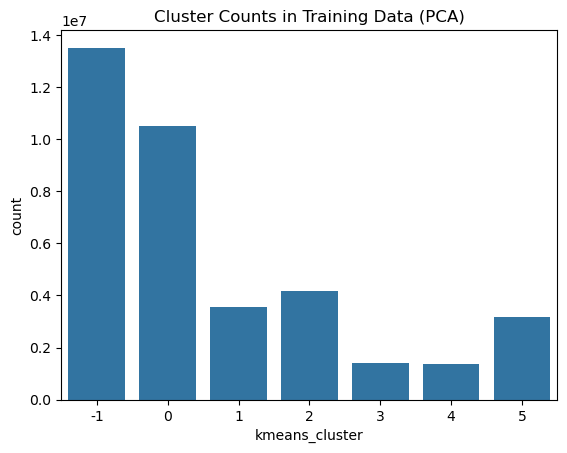

Booking rate by cluster:
kmeans_cluster
 0    0.099038
 5    0.088011
 4    0.084314
 3    0.077175
-1    0.075059
 1    0.072609
 2    0.044681
Name: is_booking, dtype: float64


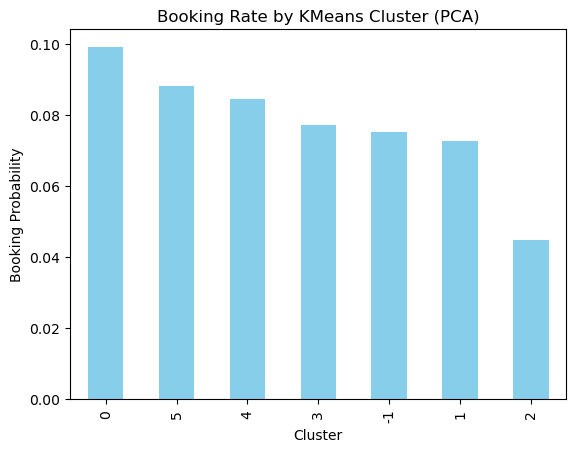

In [14]:
# Cluster counts
sns.countplot(data=train, x='kmeans_cluster')
plt.title('Cluster Counts in Training Data (PCA)')
plt.show()

# Booking rate per cluster
booking_rates = train.groupby('kmeans_cluster')['is_booking'].mean().sort_values(ascending=False)
print("Booking rate by cluster:")
print(booking_rates)

booking_rates.plot(kind='bar', color='skyblue')
plt.title("Booking Rate by KMeans Cluster (PCA)")
plt.ylabel("Booking Probability")
plt.xlabel("Cluster")
plt.show()

In [15]:
# Use only cleaned training rows
true_labels = train.loc[train_clean.index, 'hotel_cluster']
cluster_labels = train.loc[train_clean.index, 'kmeans_cluster']

ami_score = adjusted_mutual_info_score(true_labels, cluster_labels)
ari_score = adjusted_rand_score(true_labels, cluster_labels)

print(f"Adjusted Mutual Information Score (vs hotel_cluster): {ami_score:.4f}")
print(f"Adjusted Rand Index (vs hotel_cluster): {ari_score:.4f}")


Adjusted Mutual Information Score (vs hotel_cluster): 0.0636
Adjusted Rand Index (vs hotel_cluster): 0.0101


# Recommender System

In [16]:
# Recommender System based on clusters
cluster_hotel_counts = (
    train[train['is_booking'] == 1] 
    .groupby(['kmeans_cluster', 'hotel_cluster'])
    .size()
    .reset_index(name='booking_count')
)

top_hotels_per_cluster = (
    cluster_hotel_counts
    .sort_values(['kmeans_cluster', 'booking_count'], ascending=[True, False])
    .groupby('kmeans_cluster')
    .head(5)
)

print(top_hotels_per_cluster.head(10))

     kmeans_cluster  hotel_cluster  booking_count
82               -1             82          31544
46               -1             46          28832
64               -1             64          27096
59               -1             59          25618
36               -1             36          23175
191               0             91          73324
148               0             48          48944
142               0             42          40857
128               0             28          29406
150               0             50          29251


In [17]:
# Apply recommendations to test data
def recommend_hotels(user_cluster, top_k=5):
    recs = top_hotels_per_cluster[top_hotels_per_cluster['kmeans_cluster'] == user_cluster]
    return recs['hotel_cluster'].head(top_k).tolist()

test['recommended_clusters'] = test['kmeans_cluster'].apply(lambda x: recommend_hotels(x))

In [18]:
# Recommender System (Content Based)
bookings_only = train[train['is_booking'] == 1].copy()

features = [
    'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
    'is_mobile', 'is_package', 'channel', 'orig_destination_distance'
]
bookings_only = bookings_only.dropna(subset=features)
hotel_profiles = bookings_only.groupby('hotel_cluster')[features].mean()

# Standardize feature values
scaler = StandardScaler()
hotel_profiles_scaled = scaler.fit_transform(hotel_profiles)

# Compute cosine similarity between hotel clusters
similarity_matrix = cosine_similarity(hotel_profiles_scaled)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=hotel_profiles.index,
    columns=hotel_profiles.index
)

similarity_df.head()

hotel_cluster,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
hotel_cluster,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.127633,-0.847923,-0.528108,-0.338968,-0.824981,-0.319442,-0.101148,0.138888,-0.543165,...,0.356266,0.085464,0.664454,-0.002613,-0.220173,-0.250048,0.964293,-0.331299,0.246607,-0.821427
1,0.127633,1.000000,-0.039501,-0.710626,0.332036,-0.569583,0.011938,0.281790,-0.635494,-0.390002,...,-0.537505,-0.078886,-0.224906,-0.706322,-0.158517,0.069057,-0.038807,-0.448145,-0.110458,-0.142674
2,-0.847923,-0.039501,1.000000,0.426502,0.272324,0.733188,0.234958,-0.044512,-0.224346,0.446580,...,-0.626584,-0.116768,-0.637225,-0.317077,0.169301,0.309522,-0.905864,0.463638,-0.162634,0.890063
3,-0.528108,-0.710626,0.426502,1.000000,-0.300787,0.857756,-0.282953,-0.500450,0.507355,0.422175,...,0.241279,-0.214890,-0.127257,0.464956,0.008883,-0.119178,-0.413013,0.335303,0.080557,0.335705
4,-0.338968,0.332036,0.272324,-0.300787,1.000000,-0.014077,0.860576,0.770057,-0.870575,0.155971,...,-0.676668,0.773883,-0.728519,-0.585624,0.815304,0.864237,-0.281036,0.081567,0.289048,0.102802


In [19]:
def recommend_similar_clusters(hotel_cluster_id, top_k=5):
    if hotel_cluster_id not in similarity_df.index:
        return []
    similar_clusters = similarity_df.loc[hotel_cluster_id].sort_values(ascending=False)
    similar_clusters = similar_clusters.drop(hotel_cluster_id)
    return similar_clusters.head(top_k).index.tolist()

# Example 
print("Similar clusters to 91:", recommend_similar_clusters(91))
print("Similar clusters to 12:", recommend_similar_clusters(12))


def recommend_for_user(user_id, user_df=train, top_k=5):
    user_bookings = user_df[(user_df['user_id'] == user_id) & (user_df['is_booking'] == 1)]
    if user_bookings.empty:
        return []
    
    last_cluster = user_bookings.sort_values('date_time').iloc[-1]['hotel_cluster']
    return recommend_similar_clusters(last_cluster, top_k=top_k)

# Example 
print(recommend_for_user(user_id=104516))

Similar clusters to 91: [42, 16, 18, 94, 28]
Similar clusters to 12: [57, 58, 30, 85, 62]
[]


# Conclusion


This project explored unsupervised learning techniques to uncover meaningful patterns in Expedia's hotel search data. By applying Principal Component Analysis (PCA), we reduced the feature space while preserving key variance in user behavior. This step enhanced the interpretability and performance of clustering methods.

Utilizing KMeans clustering to group similar user search events based on features like travel distance, booking behavior, and mobile usage. These clusters showed distinct traveler profiles, such as last-minute mobile bookers, package deal seekers, and long-distance planners.

Finally, a simple content-based recommender system was implemented to suggest hotel clusters tailored to each user group. While not trained on labeled booking data, the system leverages behavioral similarities to make informed recommendations.

Overall, this unsupervised approach demonstrated how valuable insights and personalized recommendations can be generated without explicit labels, offering a powerful tool for businesses aiming to improve user experience through data-driven personalization.